## Project 3:  Analyze A/B Test Results - Jingjun He

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
#mismatch1: control group with new page
mismatch1 = df.query('group == "control" & landing_page == "new_page"')

#mismatch2: treatment group with old page
mismatch2 = df.query('group == "treatment" & landing_page == "old_page"')

#Total mismatch
len(mismatch1) + len(mismatch2)

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# Create new dataset that control group aligns with old_page and treatment group aligns with new_page
df2 = df.query('(group == "control" & landing_page == "old_page") or (group == "treatment" & landing_page == "new_page")')

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2['user_id'].duplicated().sum()

1

In [12]:
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.drop_duplicates(subset = 'user_id', keep = 'first')

In [15]:
#Check again for duplicates
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
len(df2.query('landing_page == "new_page"')) / df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Since there are almost equal chance that an individual receive an old page or a new page, the test is not in favor of any group. The conversion rate of an individual in the `control` group is 0.12039. The rate for the `treatment` group is 0.118808. It seems that the old page has slightly higher conversion rate than the new page, however the difference is very small. Probabilities alone are not sufficient enough to conclude that the old page has more conversions. We haven't tested the statistical significance of the results, nor have we considered other factors that may influence the results.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} \leq 0$$
$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
# Under the null, p_new and p_old are equal
p_old = p_new
p_old

0.11959708724499628

c. What is $n_{new}$?

In [22]:
n_new = len(df2.query('landing_page == "new_page"'))
n_new

145310

d. What is $n_{old}$?

In [23]:
n_old = len(df2.query('landing_page == "old_page"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.binomial(n_new, p_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.binomial(n_old, p_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
new_page_converted/n_new - old_page_converted/n_old

0.0012575220082010063

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
# simulate sampling distribution for difference in probabilities 
p_diffs = []
for _ in range(10000):
    old_page_converted = np.random.binomial(n_old, p_old)
    new_page_converted = np.random.binomial(n_new, p_new)
    diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(diff)

# convert to numpy array
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

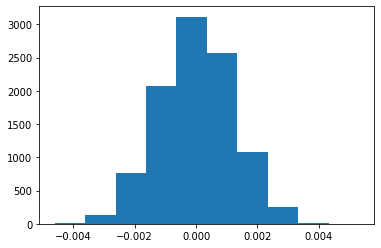

In [28]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

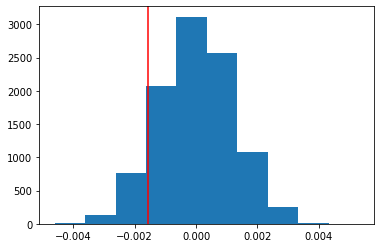

In [29]:
# Compute the observed difference
control_converted = df2.query('group == "control"').converted.mean()
treatment_converted = df2.query('group == "treatment"').converted.mean()
obs_diff = treatment_converted - control_converted 

# plot null distribution & line for observed statistic
plt.hist(p_diffs)
plt.axvline(obs_diff, c ='red');

In [30]:
# compute p-value
(p_diffs > obs_diff).mean()

0.9027

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**We just computed the p-value. P-value is the probability of getting extreme test statistic in the direction of the alternative hypothesis than the observed results, assuming that the null hypothesis is true. If the p-value is greater than the significance level (the probability of making a Type I error), do not reject the null hypothesis. In this test, we were given the Type I error rate of 5%. Since the p-value is very large, we would fail to reject the null hypothesis, meaning the old page has higher or equal convert rate than the new page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = len(df2.query('landing_page == "old_page" & converted == "1"'))
convert_new = len(df2.query('landing_page == "new_page" & converted == "1"'))
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page =="new_page"'))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')

print('z-score:', z_score)
print('p-value:', p_value)

z-score: 1.3109241984234394
p-value: 0.9050583127590245


Compute critical value of 5% Type I error rate. Compare z-score to the critical value. 

In [33]:
from scipy.stats import norm

# Define probability
p = 0.95

# Retrieve critical value 
critical_value = norm.ppf(p)

print('critical_value:', critical_value)

critical_value: 1.6448536269514722


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score tells us how many standard deviations the test statistic is away from the mean. In an upper-tailed test, the decision rule is: reject null if the z-score is larger than the critical value. The critical value associated with a 5% type I error is 1.645. Our z-score is less than the critical value, so we cannot reject the null.**

**The p-value tells us the same thing. The p-value computed above using the built-in is very close to the one computed in part j. Since the p-value is much larger than the significance level of 5%, we cannot reject the null. The z-score and p-value computed above agree with the findings in parts j. and k. Since we fail to reject the null, we can say that the old page has higher or equal conversion rate than the new page.**


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

 **Logistic Regression** 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
# Create intercept column
df2['intercept'] = 1 

# Create dummy variable column ab_page
df2[['treatment', 'control']] = pd.get_dummies(df2['group'])
df2 = df2.drop('treatment', axis = 1)
df2.rename(columns = {'control': 'ab_page'}, inplace = True)

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [35]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 02 Mar 2020   Pseudo R-squ.:               8.077e-06
Time:                        01:24:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value associated with `ab_page` is 0.19, which is different from the p-value calculated in Part II. This is because the hypothesis for the two tests are different. In Part II A/B test, the p-value tests the null hypothesis that the conversion rate of new page is not any better than the old page. In part III regression model, the p-value for independent variable (ab_page) tests the null hypothesis that the explanatory variable (ab_page) has no correlation with the response variable(converted). A large(insignificant) p-value suggests that changes in explanatory variable are not associated with changes in response variable. In the summary above, we can see that the p-value for ab_page(0.19) is greater than the significance level of 0.05, which indicates that it is not statistically significant, indicating that `ab_page` has no correlation with `converted`.**

Part II A/B test:
- Null hypothesis: The conversion rate for the new page is smaller or equal to the old page.
- Alternative hypothesis: The conversion rate for the new page is greater than the old page.

Part III Regression model:
- Null Hypothesis: `ab_page` has no correlation with `converted`. 
- Alternative Hypothesis: `ab_page` has correlation with `converted`.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Since the p-value for ab_page is higher than the 5% significance level, we fail to reject the null that `ab_page` has no correlation with `converted`. We should also consider other factors that might influence an individual's decision to convert or not. We could add time duration each user's spent on the page, because the more time a user spent on the page, the more likely the person may decide to convert. We could divide users into different age groups since they may have difference preferences. Gender can be another factor to consider. Whether a user is an existing customer already can also be considered.**

**When adding additional predictor variables to the regression model, we should consider the relationships among variables. When we have predictor variables that are correlated with one another, it could lead to multi-collinearity. More importantly, more variables does not mean better model. We should pick most important variables.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [38]:
# Check values for country column
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [39]:
# Create the necessary dummy variables
df_new[['US', 'UK', 'CA']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [40]:
# Fit Your Linear Model And Obtain the Results
# Use US as baseline 
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept','ab_page', 'UK', 'CA']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 02 Mar 2020   Pseudo R-squ.:               2.323e-05
Time:                        01:24:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
CA             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

**From the summary output, we can see that the p-value for predictor variables UK and CA are 0.074 and 0.13 respectively, none of which are statistically significant(5% significance level). We fail to reject the null hypothesis that the predictor variable `UK`, `CA` has no correlation with reponse variable `converted`.**

<a id='conclusions'></a>
## Conclusions

We have used three different methods to test whether the new page is better than the old page with regard to the conversion rate. In Part I Probability, we found that the old page(0.12039) has slightly higher conversion rate than the new page(0.11881). In Part II A/B Test, we fail to reject the null hypothesis that the old page has higher or equal conversion rate than the new page, so we accept the null. In Part III Regression, the test results show that which page a customer receives and country a user lives has no correlation with the conversion. Based on the results so far, we have no evidence to say the new page is better. We should just keep the old page. However, there are some limitations we should consider and we can introduce other factors into the model such as user's time spent on the page, age group, gender, user status(existing customer or not) as we discussed in partIII f. for further analysis. 

**Limitations:**
- We should also consider novelty effect and change aversion that existing users may have.
- We are not clear about how long it takes for the new pages to account for changes in behavior.
- We should also consider practical significance. The costs of launching a new page and the gain from the increase in conversion.


## References
https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python
<br> https://online.stat.psu.edu/statprogram/reviews/statistical-concepts/hypothesis-testing/p-value-approach
<br>https://support.minitab.com/en-us/minitab/19/help-and-how-to/statistics/basic-statistics/how-to/1-sample-z/interpret-the-results/all-statistics-and-graphs/#z-value
<br>http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_HypothesisTest-Means-Proportions/BS704_HypothesisTest-Means-Proportions3.html
<br>https://machinelearningmastery.com/critical-values-for-statistical-hypothesis-testing/